In [1]:
import sys
!{sys.executable} -m pip install numpy catboost
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install catboost
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
# new import statements
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
import optuna

### Retailrocket recommender system dataset

Source: https://www.kaggle.com/retailrocket/ecommerce-dataset

Load the dataset files.

In [3]:
events = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'events.csv'))
item_properties = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'item_properties_part1.csv'))
category_tree = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'category_tree.csv'))

In [4]:
events['event_datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
events['event_date'] = events['event_datetime'].dt.date
events

,timestamp,visitorid,event,itemid,transactionid,event_datetime,event_date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02
...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,2015-08-01
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,2015-08-01
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2015-08-01
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,2015-08-01


In [5]:
item_properties

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [6]:
category_tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


Extract `categoryid` data from `item_properties`.

In [7]:
category_items = item_properties[item_properties['property'] == 'categoryid'][['itemid', 'value']]
# 'value' column contains the category IDs, so let's rename value to categoryid
category_items.columns = ['itemid', 'categoryid']  
category_items['categoryid'] = category_items['categoryid'].astype(int)
category_items

,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47
...,...,...
10999880,441523,1167
10999917,250848,769
10999932,116380,1509
10999960,84186,209


Merge `events` with `category_items`.

In [8]:
events_with_categories = pd.merge(events, category_items, on="itemid", how="left")
events_with_categories

,timestamp,visitorid,event,itemid,transactionid,event_datetime,event_date,categoryid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02,1173.0
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02,NaN
...,...,...,...,...,...,...,...,...
4439576,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,2015-08-01,NaN
4439577,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,2015-08-01,1616.0
4439578,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2015-08-01,969.0
4439579,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,2015-08-01,NaN


In [9]:
grouped_data = (
    events_with_categories[events_with_categories['event'] == 'view']
    .groupby(['event_date', 'categoryid'])
    .size()
    .reset_index(name='view_count') 
)
grouped_data

,event_date,categoryid,view_count
0,2015-05-03,0.0,3
1,2015-05-03,1.0,17
2,2015-05-03,3.0,5
3,2015-05-03,5.0,31
4,2015-05-03,14.0,63
...,...,...,...
95935,2015-09-18,1650.0,3
95936,2015-09-18,1659.0,6
95937,2015-09-18,1663.0,3
95938,2015-09-18,1680.0,1


In [10]:
per_day_data = grouped_data.groupby('event_date')['view_count'].sum().reset_index()
per_day_data

,event_date,view_count
0,2015-05-03,16405
1,2015-05-04,22200
2,2015-05-05,25861
3,2015-05-06,26558
4,2015-05-07,27054
...,...,...
134,2015-09-14,20405
135,2015-09-15,20149
136,2015-09-16,11647
137,2015-09-17,11968


### ARIMA `q` determination

- `q`: The order of the Moving Average (MA) Term
- What is `q`? The number of lagged forecast errors included in the model.
- How to determine it from ACF plot?
    - Look for a significant spike and where it cuts off. The lag at the cut-off point indicates q.

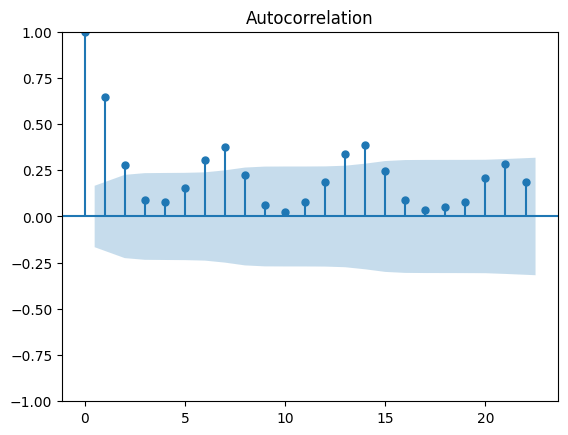

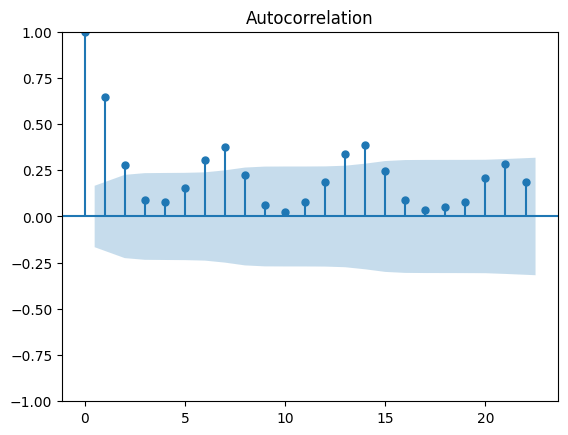

In [11]:
plot_acf(per_day_data['view_count'])

### ARIMA `p` determination

- `p`: The order of the Autoregressive (AR) Term
- What is `p`? The number of lagged observations used to predict the series.
- How to determine it from PACF plot?
    - Look for a significant spike (above the confidence interval) and where it cuts off. The lag at the cut-off point indicates p.

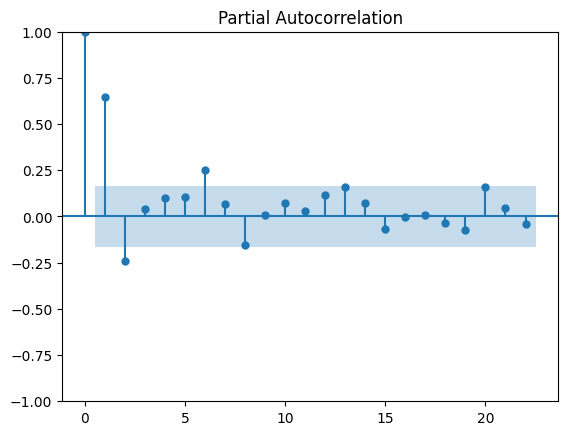

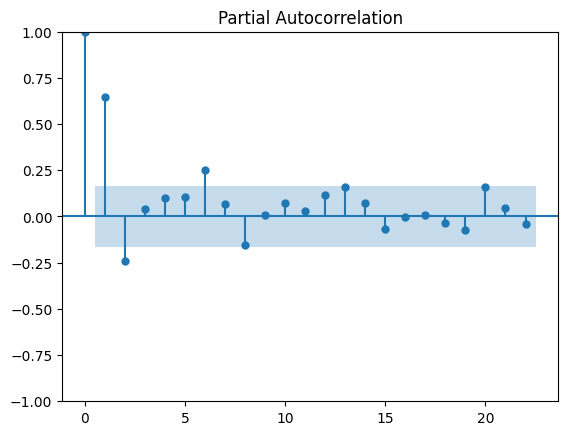

In [12]:
plot_pacf(per_day_data['view_count'])

### Differencing

Differencing is a technique used in time series analysis to transform a non-stationary series into a stationary series by subtracting the current value of the series from its previous value. The goal of differencing is to eliminate trends, seasonality, and other non-stationary components to make the series more suitable for modeling with methods like ARIMA. A stationary series has constant mean, variance, and autocorrelation over time.

In [13]:
grouped_data

,event_date,categoryid,view_count
0,2015-05-03,0.0,3
1,2015-05-03,1.0,17
2,2015-05-03,3.0,5
3,2015-05-03,5.0,31
4,2015-05-03,14.0,63
...,...,...,...
95935,2015-09-18,1650.0,3
95936,2015-09-18,1659.0,6
95937,2015-09-18,1663.0,3
95938,2015-09-18,1680.0,1


In [14]:
grouped_data['diff_view_count'] = grouped_data['view_count'].diff()
grouped_data

,event_date,categoryid,view_count,diff_view_count
0,2015-05-03,0.0,3,NaN
1,2015-05-03,1.0,17,14.0
2,2015-05-03,3.0,5,-12.0
3,2015-05-03,5.0,31,26.0
4,2015-05-03,14.0,63,32.0
...,...,...,...,...
95935,2015-09-18,1650.0,3,1.0
95936,2015-09-18,1659.0,6,3.0
95937,2015-09-18,1663.0,3,-3.0
95938,2015-09-18,1680.0,1,-2.0


In [15]:
grouped_data = grouped_data.dropna()
grouped_data

,event_date,categoryid,view_count,diff_view_count
1,2015-05-03,1.0,17,14.0
2,2015-05-03,3.0,5,-12.0
3,2015-05-03,5.0,31,26.0
4,2015-05-03,14.0,63,32.0
5,2015-05-03,23.0,1,-62.0
...,...,...,...,...
95935,2015-09-18,1650.0,3,1.0
95936,2015-09-18,1659.0,6,3.0
95937,2015-09-18,1663.0,3,-3.0
95938,2015-09-18,1680.0,1,-2.0


### Visual difference between original series and differentiated series

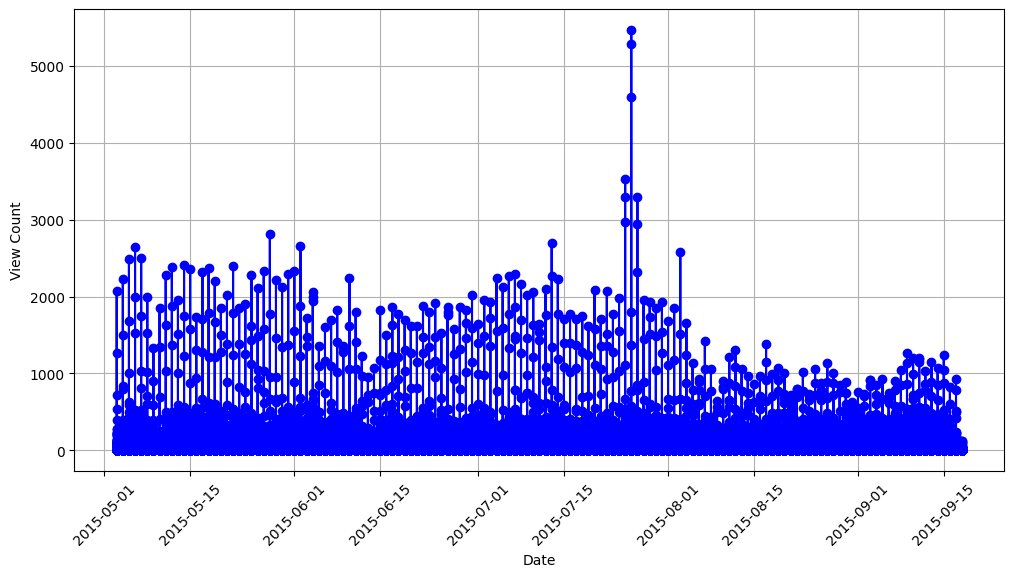

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(grouped_data['event_date'], grouped_data['view_count'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('View Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

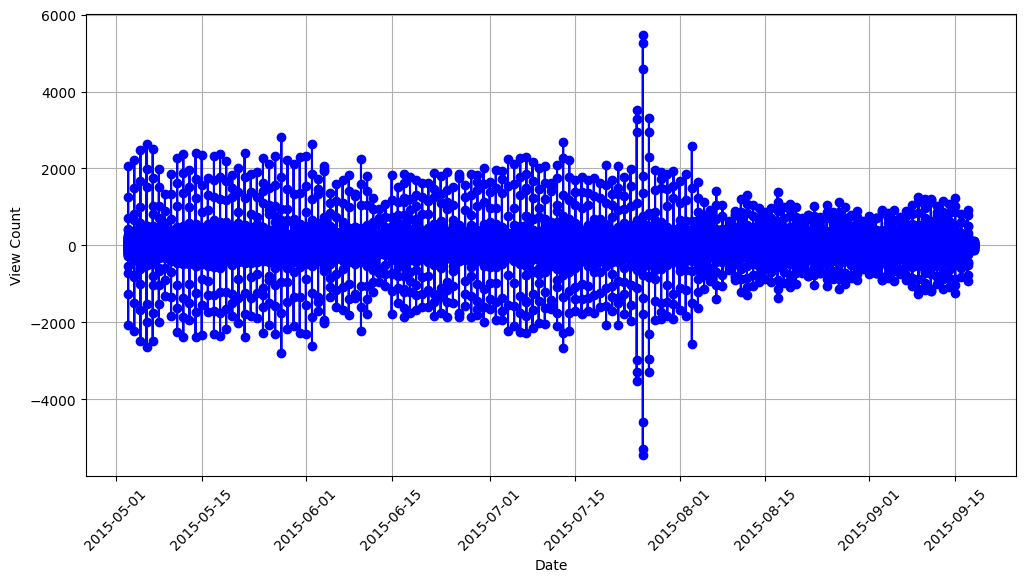

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(grouped_data['event_date'], grouped_data['diff_view_count'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('View Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Augmented Dickey-Fuller (ADF) test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis (H₀) that the time series has a unit root, indicating non-stationarity. The alternative hypothesis (H₁) is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [18]:
result = adfuller(grouped_data['diff_view_count'][:10000])

adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -28.023070902781225
p-value: 0.0


### ARIMA

In [19]:
d = 1 
p = 2
q = 2

It is recommended to convert your data type to `float64` before performing ARIMA forecasting.

In [20]:
model = sm.tsa.ARIMA(grouped_data['view_count'].values.astype('float64'), order=(p, d, q))
result = model.fit()

In [21]:
result

In [22]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                95939
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -586800.741
Date:                Mon, 21 Apr 2025   AIC                        1173611.483
Time:                        18:04:27   BIC                        1173658.840
Sample:                             0   HQIC                       1173625.881
                              - 95939                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6392      0.201     -3.174      0.002      -1.034      -0.244
ar.L2         -0.0281      0.007     -3.865      0.000      -0.042      -0.014
ma.L1         -0.3796      0.202     -1.884      0.0

#### Prediction for the next 30 days

In [23]:
predictions = result.forecast(steps=30)
print(predictions)

[21.81335872 21.33634588 21.08502593 21.25906919 21.15487087 21.21659159
 21.18006304 21.20168048 21.18888745 21.19645827 21.19197791 21.19462935
 21.19306025 21.19398883 21.1934393  21.19376451 21.19357206 21.19368595
 21.19361855 21.19365844 21.19363483 21.1936488  21.19364053 21.19364543
 21.19364253 21.19364424 21.19364323 21.19364383 21.19364347 21.19364368]


## Revisiting EMA: Forecasting Formula

The Exponential Moving Average at time *t* is defined recursively as:

$$\text{EMA}_t = \alpha \cdot x_t + (1 - \alpha) \cdot \text{EMA}_{t-1}$$

Where:  
- $\text{EMA}_t$ is the EMA at time *t*  
- $x_t$ is the actual observed value at time *t*  
- $\alpha$ is the smoothing factor: $\alpha = \frac{2}{span + 1}$

---

### Forecasting with EMA (when actual values are unknown):

If you're forecasting into the future without actual observations, the EMA becomes constant:

$$
\text{EMA}_{t+1} = \text{EMA}_t
$$

This is because there's no new $x_t$ to update the EMA, so it flattens out using the last known EMA value.


## Gradient Boosting techniques

### Time series forecasting requirements: supervised learning

While boosting techniques can be used for time series forecasting, it requires that the time series dataset be transformed into a supervised learning problem first. It also requires the use of a specialized technique for evaluating the model called walk-forward validation, as evaluating the model using k-fold cross validation would result in optimistically biased results.

### Walk-forward validation

In walk-forward validation, the dataset is first split into train and test sets by selecting a cut point, e.g. all data except the last 12 days is used for training and the last 12 days is used for testing.

- Splitting the data into multiple overlapping train-validation folds, where each fold includes:
    - A growing training set (e.g., using data from t=0 to t=n).
    - A validation set that follows the training set (e.g., data from t=n+1 to t=n+m).
Training and evaluating the model on each fold.

In [24]:
grouped_data = (
    events_with_categories[events_with_categories['event'] == 'view']
    .groupby(['timestamp', 'event_datetime', 'categoryid'])
    .size()
    .reset_index(name='view_count') 
)
grouped_data

,timestamp,event_datetime,categoryid,view_count
0,1430622028399,2015-05-03 03:00:28.399,421.0,5
1,1430622028399,2015-05-03 03:00:28.399,1674.0,13
2,1430622033686,2015-05-03 03:00:33.686,1339.0,1
3,1430622036210,2015-05-03 03:00:36.210,368.0,1
4,1430622040988,2015-05-03 03:00:40.988,683.0,1
...,...,...,...,...
1459107,1442545134195,2015-09-18 02:58:54.195,1196.0,1
1459108,1442545152365,2015-09-18 02:59:12.365,1293.0,1
1459109,1442545153842,2015-09-18 02:59:13.842,956.0,1
1459110,1442545174109,2015-09-18 02:59:34.109,491.0,1


In [25]:
# Train-Test Split
train, test = train_test_split(grouped_data, test_size=0.2, random_state=42, shuffle=False)

first_date = test['event_datetime'].min()
last_date = test['event_datetime'].max()

print(f"Testing period: {first_date} to {last_date}")

# Assumption: the validation set should be the same length as the test set 
# and immediately precede it
validation_duration = last_date - first_date
val_start_date = first_date - validation_duration
val_end_date = first_date - pd.Timedelta(seconds=1)

# Filter the train set to define the validation set
val = train[(train['event_datetime'] >= val_start_date) & (train['event_datetime'] <= val_end_date)]

print(f"Validation period: {val_start_date} to {val_end_date}")
print(f"Number of records in validation set: {len(val)}")

# Remove validation set from training set to prevent data leakage
train = train[~train.index.isin(val.index)]

Testing period: 2015-08-17 22:28:00.761000 to 2015-09-18 02:59:41.778000
Validation period: 2015-07-17 17:56:19.744000 to 2015-08-17 22:27:59.761000
Number of records in validation set: 330165


### Time series forecasting with gradient boosting: LightGBM, XGBoost 

Tree-based machine learning methods designed to improve gradient boosting decision trees (GBDT) --- for regression and classification tasks.

Key benefits of using gradient boosting models for forecasting include:

- The ease with which exogenous variables can be included in the model, in addition to autoregressive variables.
- The ability to capture non-linear relationships between variables.
- High scalability, allowing models to handle large volumes of data.
- Some implementations allow the inclusion of categorical variables without the need for additional encoding, such as one-hot encoding.

Challenges of using boosting techniques for forecasting:

- Transforming the data so that it can be used as a regression problem.
- Depending on how many future predictions are needed (prediction horizon), an iterative process may be required where each new prediction is based on previous ones.
- Model validation requires specific strategies such as backtesting, walk-forward validation or time series cross-validation. Traditional cross-validation cannot be used.

### LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel, distributed, and GPU learning.
- Capable of handling large-scale data.

LightGBM builds decision trees iteratively. Key feature: Uses leaf-wise growth, where the tree expands its most significant leaf nodes first. This can result in deeper, more focused trees and faster convergence.

Optimizations:
- Handles large datasets efficiently.
- Uses a histogram-based algorithm for faster computation.
- Includes mechanisms for dealing with categorical features natively.

In [28]:
# Define features and labels
features = ['timestamp', 'categoryid']  # Use the numerical timestamp
Y_train = train['view_count']
X_train = train[features]
X_train['categoryid'] = X_train['categoryid'].astype("category")

Y_val = val['view_count']
X_val = val[features]
X_val['categoryid'] = X_val['categoryid'].astype("category")

Y_test = test['view_count']
X_test = test[features]
X_test['categoryid'] = X_test['categoryid'].astype("category")

# LightGBM Dataset
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=features)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=features)

# Define RMSLE Metric
def rmsle(y_pred, y_true):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

def lgbm_rmsle(preds, train_data):
    labels = train_data.get_label()
    rmsle_val = rmsle(preds, labels)
    return 'RMSLE', rmsle_val, False

# LightGBM Parameters
lgb_params = {
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'max_depth': 6,
    'verbose': 1,
    'num_boost_round': 5000,
    'early_stopping_rounds': 100,
    'nthread': -1,
}

# Train LightGBM Model
model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    feval=lgbm_rmsle
)

# Predictions on Validation Set
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
val_rmsle = rmsle(y_pred_val, Y_val)
print(f"Validation RMSLE: {val_rmsle}")

# Predictions on Test Set
test_preds = model.predict(X_test, num_iteration=model.best_iteration)
test_rmsle = rmsle(test_preds, Y_test)
print(f"Test RMSLE: {test_rmsle}")

# Output predictions
test['predicted_view_count'] = test_preds
print(test[['event_datetime', 'categoryid', 'view_count', 'predicted_view_count']].head())

/tmp/ipykernel_743517/446704201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['categoryid'] = X_train['categoryid'].astype("category")
/tmp/ipykernel_743517/446704201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['categoryid'] = X_val['categoryid'].astype("category")
/tmp/ipykernel_743517/446704201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 837124, number of used features: 2
[LightGBM] [Info] Start training from score 2.082992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's l2: 2.7401	training's RMSLE: 0.294389	valid_1's l2: 2.73785	valid_1's RMSLE: 0.295956
Validation RMSLE: 0.2959559444152678
Test RMSLE: 0.3028402919334681
                 event_datetime  categoryid  view_count  predicted_view_count
1167289 2015-08-17 